In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from datetime import datetime
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow as tf

# Diretórios dos dados
DATA_DIR = "C:/Repositorios/Meus/PAI-Detecao-de-doencas-em-plantas-com-visao-computacional/data/raw/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VALID_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR = "data/raw/new-plant-diseases-dataset/test/test"

print(f"Diretório de treino: {TRAIN_DIR}")
print(f"Diretório de validação: {VALID_DIR}")
print(f"Diretório de teste: {TEST_DIR}")


Diretório de treino: C:/Repositorios/Meus/PAI-Detecao-de-doencas-em-plantas-com-visao-computacional/data/raw/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
Diretório de validação: C:/Repositorios/Meus/PAI-Detecao-de-doencas-em-plantas-com-visao-computacional/data/raw/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid
Diretório de teste: data/raw/new-plant-diseases-dataset/test/test


In [2]:
# Listar as classes selecionadas
classes_selecionadas = [
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___Northern_Leaf_Blight",
    "Corn_(maize)___healthy",
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Target_Spot",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato___healthy"
]

print(f"Classes selecionadas: {classes_selecionadas}")
print(f"Quantidade de classes: {len(classes_selecionadas)}")


Classes selecionadas: ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy']
Quantidade de classes: 15


In [3]:
def carregar_dados_com_filtro(data_dir, classes, limite_por_classe=100):
    imagens = []
    rotulos = []
    
    total_imagens = sum([min(len(glob(os.path.join(data_dir, classe, "*.*"))), limite_por_classe) for classe in classes])
    progress_bar = tqdm(total=total_imagens, desc="Carregando imagens", unit="imagens")

    for classe_idx, classe in enumerate(classes):
        classe_dir = os.path.join(data_dir, classe)
        imagens_classe = glob(os.path.join(classe_dir, "*.*"))[:limite_por_classe]
        for img_path in imagens_classe:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Erro ao carregar a imagem: {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))  # MobileNetV2 usa 224x224
            img = preprocess_input(img)  # Preprocessamento específico do MobileNetV2
            imagens.append(img)
            rotulos.append(classe_idx)
            progress_bar.update(1)

    progress_bar.close()
    return np.array(imagens), np.array(rotulos)


In [4]:
# Carregar os dados de treino e validação
X_train, y_train = carregar_dados_com_filtro(TRAIN_DIR, classes_selecionadas, limite_por_classe=500)
X_valid, y_valid = carregar_dados_com_filtro(VALID_DIR, classes_selecionadas, limite_por_classe=100)

print(f"Conjunto de treino: {X_train.shape}, Rótulos: {y_train.shape}")
print(f"Conjunto de validação: {X_valid.shape}, Rótulos: {y_valid.shape}")


Carregando imagens:   0%|          | 0/7500 [00:00<?, ?imagens/s]

Carregando imagens:   0%|          | 0/1500 [00:00<?, ?imagens/s]

Conjunto de treino: (7500, 224, 224, 3), Rótulos: (7500,)
Conjunto de validação: (1500, 224, 224, 3), Rótulos: (1500,)


In [5]:
# Definir o modelo usando MobileNetV2 pré-treinado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas do modelo base
base_model.trainable = False

# Adicionar camadas personalizadas
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes_selecionadas), activation='softmax')
])

# Exibir o resumo do modelo
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                                 
Total params: 2,589,775
Trainable params: 331,791
Non-tr

In [6]:
# Verificar dispositivos físicos disponíveis
dispositivos = tf.config.list_physical_devices()
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"GPUs disponíveis: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f" - GPU {i}: {gpu.name}")
    print("\nTreinamento será realizado utilizando GPU.")
else:
    print("Nenhuma GPU encontrada. Treinamento será realizado utilizando CPU.")

GPUs disponíveis: 1
 - GPU 0: /physical_device:GPU:0

Treinamento será realizado utilizando GPU.


In [7]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
# Callbacks para treinamento
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Treinamento do modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,  # Você pode ajustar o número de épocas
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
469/469 [==============================] - 13s 18ms/step - loss: 1.4317 - accuracy: 0.5524 - val_loss: 0.6369 - val_accuracy: 0.8287 - lr: 1.0000e-04
Epoch 2/50
469/469 [==============================] - 7s 16ms/step - loss: 0.6459 - accuracy: 0.7953 - val_loss: 0.4241 - val_accuracy: 0.8820 - lr: 1.0000e-04
Epoch 3/50
469/469 [==============================] - 8s 16ms/step - loss: 0.4763 - accuracy: 0.8489 - val_loss: 0.3519 - val_accuracy: 0.8953 - lr: 1.0000e-04
Epoch 4/50
469/469 [==============================] - 8s 17ms/step - loss: 0.3822 - accuracy: 0.8784 - val_loss: 0.3102 - val_accuracy: 0.9033 - lr: 1.0000e-04
Epoch 5/50
469/469 [==============================] - 8s 17ms/step - loss: 0.3189 - accuracy: 0.8973 - val_loss: 0.2608 - val_accuracy: 0.9160 - lr: 1.0000e-04
Epoch 6/50
469/469 [==============================] - 8s 16ms/step - loss: 0.2710 - accuracy: 0.9135 - val_loss: 0.2469 - val_accuracy: 0.9200 - lr: 1.0000e-04
Epoch 7/50
469/469 [===================

In [9]:
# Criar diretório para salvar os resultados
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"MobileNetV2_{timestamp}"
model_path = os.path.join("modelos", model_name)
os.makedirs(model_path, exist_ok=True)
print(f"Gráficos serão salvos na pasta: {model_path}")


Gráficos serão salvos na pasta: modelos\MobileNetV2_20241130_191710


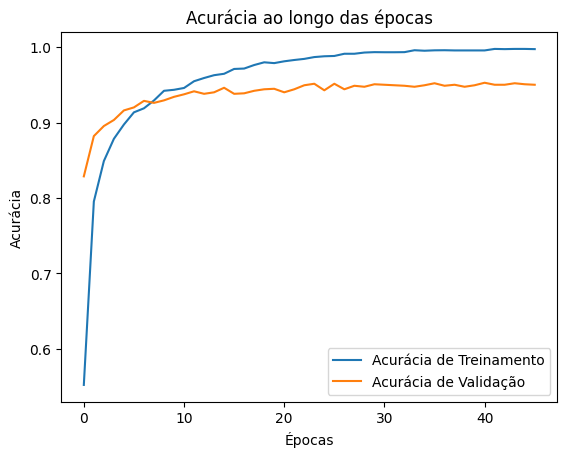

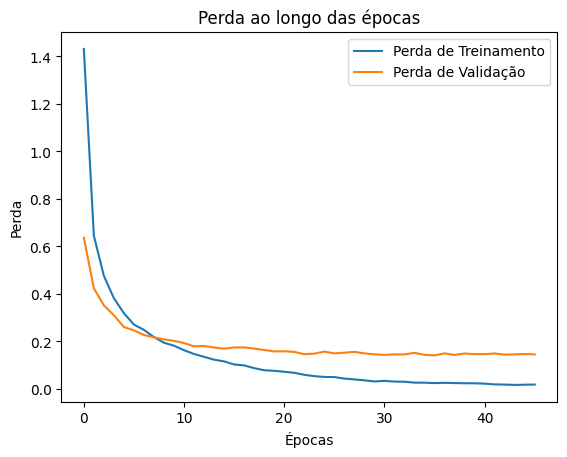

In [10]:
# Plotar a acurácia
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Acurácia ao longo das épocas')
plt.savefig(os.path.join(model_path, 'accuracy.png'), dpi=300, bbox_inches='tight')
plt.show()

# Plotar a perda
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Perda ao longo das épocas')
plt.savefig(os.path.join(model_path, 'loss.png'), dpi=300, bbox_inches='tight')
plt.show()

47/47 [==============================] - 1s 21ms/step


<Figure size 1200x1000 with 0 Axes>

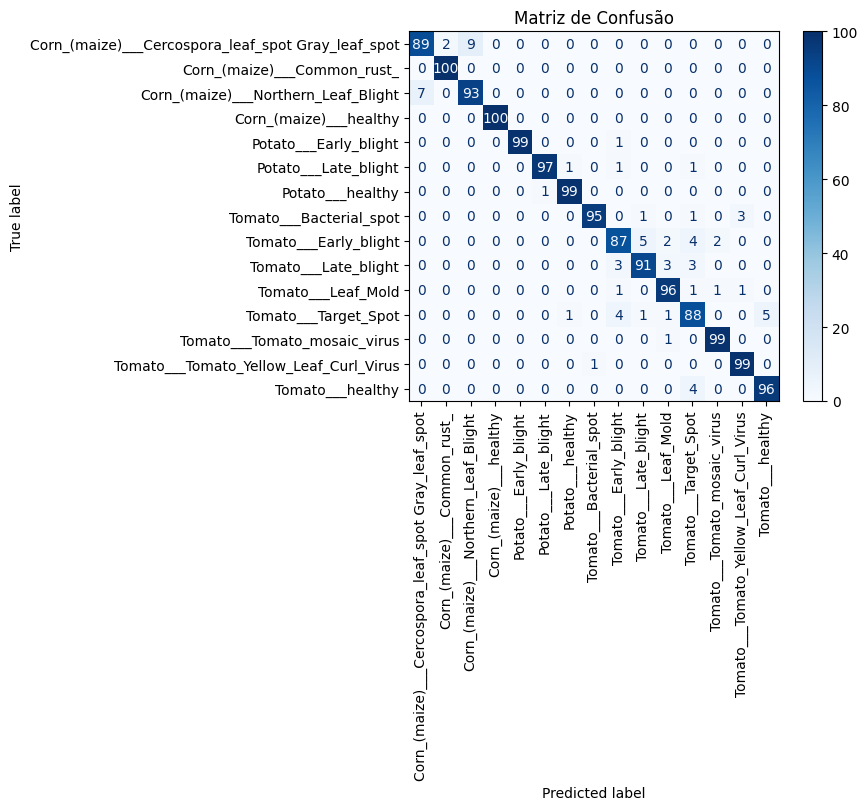

In [12]:
# Predict probabilities for the validation set
y_pred = model.predict(X_valid)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)  # Find the index of the maximum probability
# Create the confusion matrix
conf_matrix = confusion_matrix(y_valid, y_pred_classes)

# Set the figure size before plotting
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes_selecionadas)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', colorbar=True)  # Remove figsize from here
plt.title('Matriz de Confusão')
plt.savefig(os.path.join(model_path, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

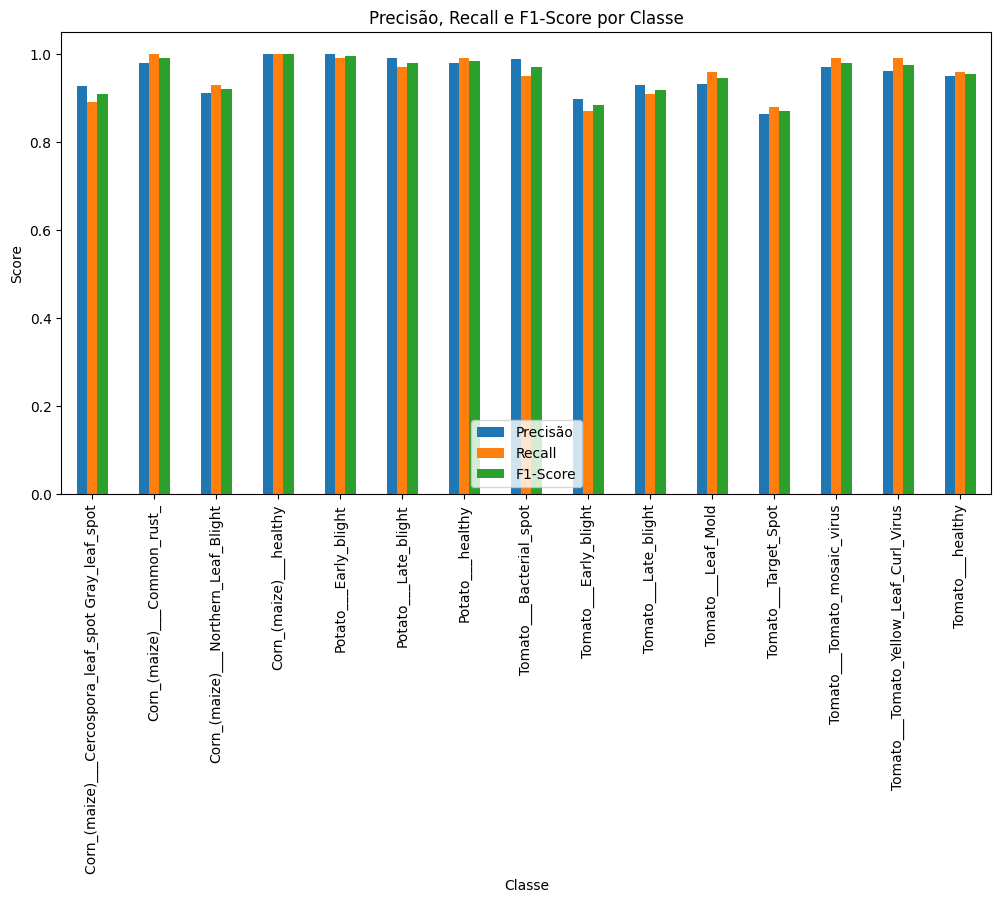

In [13]:
# Gerar o relatório de classificação
report = classification_report(y_valid, y_pred_classes, target_names=classes_selecionadas, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plotar precisão, recall e f1-score por classe
metrics = ['precision', 'recall', 'f1-score']
report_df[metrics].iloc[:-3].plot(kind='bar', figsize=(12, 6))
plt.title('Precisão, Recall e F1-Score por Classe')
plt.ylabel('Score')
plt.xlabel('Classe')
plt.legend(['Precisão', 'Recall', 'F1-Score'])
plt.savefig(os.path.join(model_path, 'precision_recall_f1.png'), dpi=300, bbox_inches='tight')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.47450984].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7490196].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].


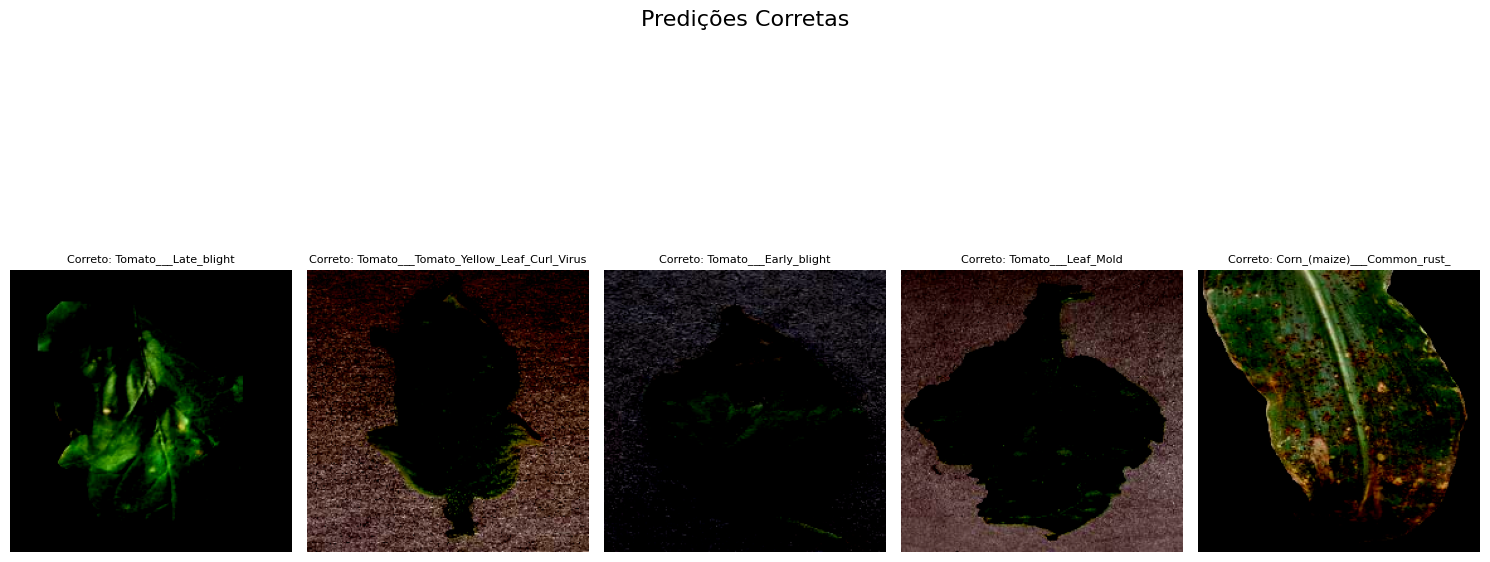

In [14]:
# Predições corretas
correct = np.where(y_valid == y_pred_classes)[0]

# Exibir 5 imagens corretamente classificadas
plt.figure(figsize=(15, 8))  # Aumentar o tamanho da figura
for i, idx in enumerate(random.sample(list(correct), 5)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_valid[idx])
    plt.title(
        f"Correto: {classes_selecionadas[y_valid[idx]]}", 
        fontsize=8  # Reduzir o tamanho da fonte
    )
    plt.axis("off")
plt.suptitle("Predições Corretas", fontsize=16)  # Ajustar o tamanho do título principal
plt.tight_layout()
plt.savefig(os.path.join(model_path, 'predicoes_corretas.png'), dpi=300, bbox_inches='tight')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5058824].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.7647059].


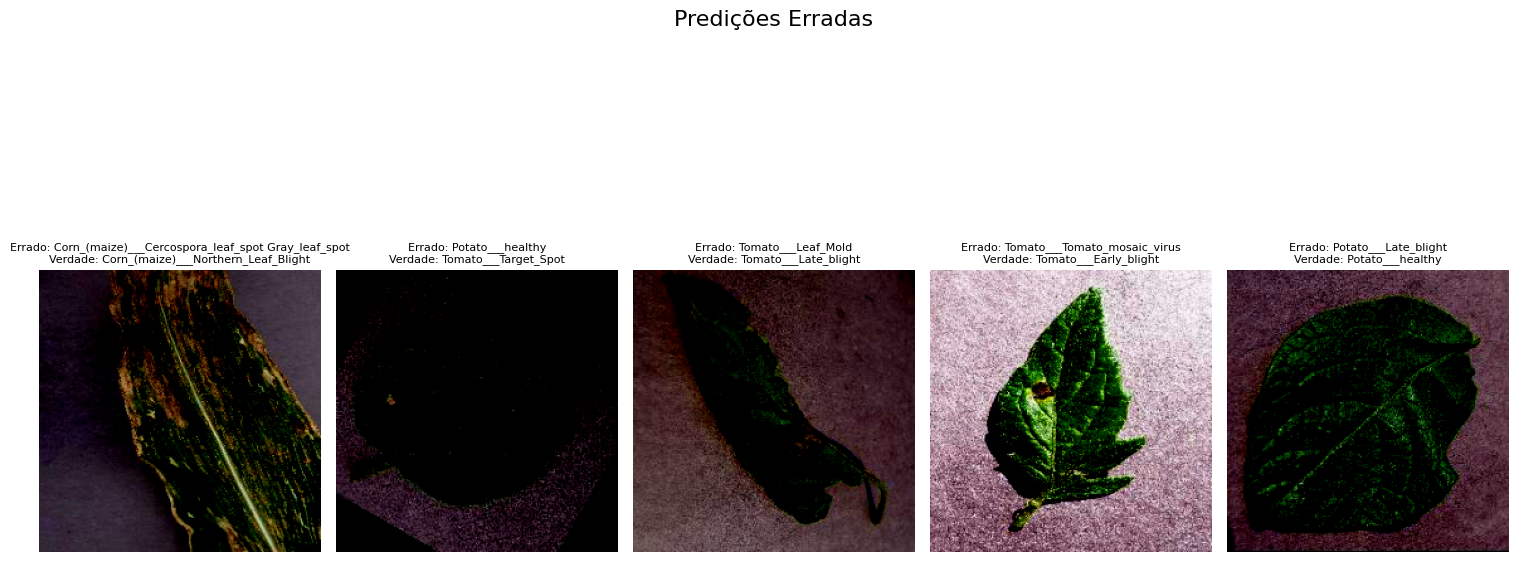

In [15]:
# Predições erradas
incorrect = np.where(y_valid != y_pred_classes)[0]

# Exibir 5 imagens incorretamente classificadas
plt.figure(figsize=(15, 8))  # Increase figure size for clarity
for i, idx in enumerate(random.sample(list(incorrect), 5)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_valid[idx])
    plt.title(
        f"Errado: {classes_selecionadas[y_pred_classes[idx]]}\nVerdade: {classes_selecionadas[y_valid[idx]]}",
        fontsize=8  # Reduce font size
    )
    plt.axis("off")
plt.suptitle("Predições Erradas", fontsize=16)  # Adjust the overall title font size
plt.tight_layout()
plt.savefig(os.path.join(model_path, 'predicoes_erradas.png'), dpi=300, bbox_inches='tight')
plt.show()

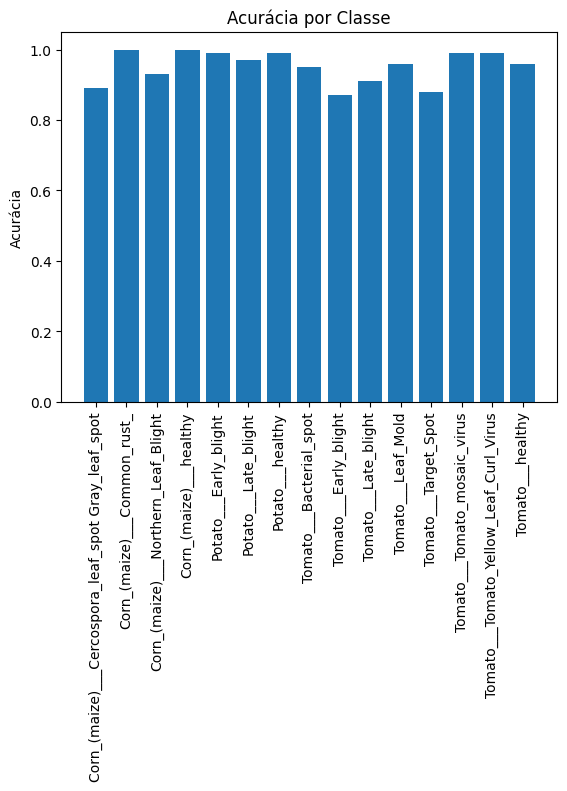

In [16]:
# Calcular acurácia por classe
class_accuracies = {}
for i, classe in enumerate(classes_selecionadas):
    idxs = np.where(y_valid == i)[0]
    class_accuracy = accuracy_score(y_valid[idxs], y_pred_classes[idxs])
    class_accuracies[classe] = class_accuracy

# Plotar acurácia por classe
plt.bar(class_accuracies.keys(), class_accuracies.values())
plt.xticks(rotation=90)
plt.ylabel('Acurácia')
plt.title('Acurácia por Classe')
plt.savefig(os.path.join(model_path, 'accuracy_by_class.png'), dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# Avaliar no conjunto de validação
val_loss, val_accuracy = model.evaluate(X_valid, y_valid)
print(f"Perda no conjunto de validação: {val_loss:.4f}")
print(f"Acurácia no conjunto de validação: {val_accuracy:.4f}")

47/47 [==============================] - 1s 23ms/step - loss: 0.1414 - accuracy: 0.9520
Perda no conjunto de validação: 0.1414
Acurácia no conjunto de validação: 0.9520


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.4039216].


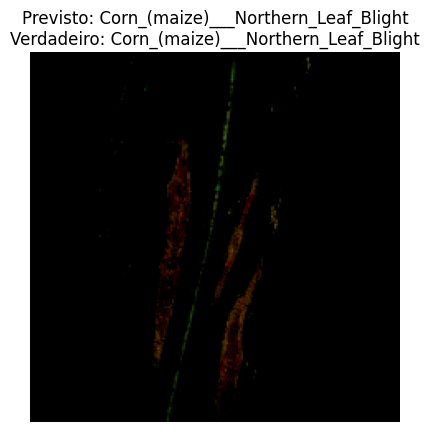

In [18]:
# Escolher uma imagem aleatória do conjunto de validação
idx = random.randint(0, len(X_valid) - 1)
img = X_valid[idx]
true_label = y_valid[idx]

# Fazer a predição
prediction = model.predict(img[np.newaxis, ...])  # Adiciona dimensão de batch
predicted_label = classes_selecionadas[np.argmax(prediction)]

# Visualizar a imagem e o resultado
plt.imshow(img)
plt.title(f"Previsto: {predicted_label}\nVerdadeiro: {classes_selecionadas[true_label]}")
plt.axis("off")
plt.show()

In [19]:
# Gerar timestamp no formato YYYY_MM_DD_HH_MM_SS
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Salvar o modelo com a data no nome
model.save(os.path.join(model_path, f'plant_disease_model_{timestamp}.h5'))